# Downloading SP500 history available using the  yfinance tool


In [88]:
# Library that gives us access to S&P500 Stock data
import yfinance as yf

# Libraries that gives us access to read information from the web
import requests as rq
from bs4 import BeautifulSoup as bs

# Allows us to view the data and make changes to it
import pandas as pd

import matplotlib

# Storing this data into variable (contained in a Pandas data frame)
sp500 = yf.Ticker("^GSPC")

# Requesting the max history of the index
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

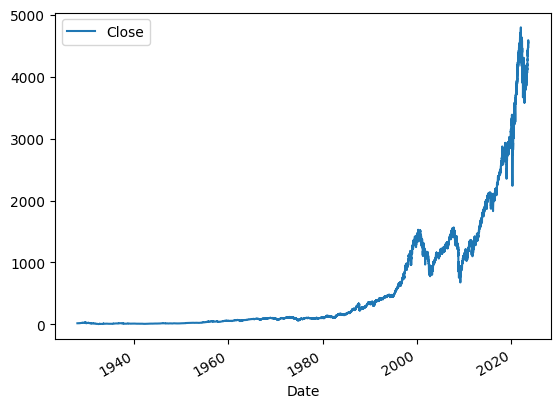

In [89]:
# Plots a line of the index to see progression of the index over time
sp500.plot.line(y="Close", use_index=True)

# Cleaning and visualizing our stock market data

In [90]:
# Delete the Dividend and Stock Split Columns from the PD DF (Not needed for Indexes
del sp500["Dividends"]
del sp500["Stock Splits"]

# Setting up the target for machine learning

In [91]:
# Creating a column called tomorrow (holding tomorrow's price)
# Using pandas shift column to shift these prices back on day
sp500["Tomorrow"] = sp500["Close"].shift(-1)

# This target is what we are trying to predict with machine learning
# Convert this into a int so that it is easier to manage
# 0 for down, 1 for up
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Removing all data before 1990
# This is because market fundementals shift over time
sp500 = sp500.loc["1990-01-01":].copy()

# Training an intial machine learning model

In [92]:
# Intializing our Machine Learning Code
from sklearn.ensemble import RandomForestClassifier

# using this ML model because it is better when looking at over fitting
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Splitting data into a train and test
# Because this is time data, we cannot use cross validation because this leads to leakage
train = sp500.iloc[:-100] # Taking all rows except the last 100 rows for ftraining
test = sp500.iloc[-100:] # Putting the last 100 rows for testing

# These are the metrics that we are passing into the Neural Network to predict the targets
predictors = ["Close", "Volume", "Open", "High", "Low"]

# ML Code that fits these predictors onto our target (data, answer = how we got there)
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

# Building a System to Backtest

In [93]:
# Measuring how accurate our ML Code is
from sklearn.metrics import precision_score

# Generate predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
combined = pd.concat([test["Target"], preds], axis=1)

In [94]:
def predict(train, test, predictions, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [95]:
# Back test function
def backtest(data, model, predictors, start=2500, step=250):
    # Creating a list that holds all our predictions
    all_predictions = []

    # Creating a function that loops over all of our data
    for i in range(start, data.shape[0], step):
        # Split train and test data
        train = data.iloc[0:i].copy()
        test= data.iloc[i:(i+step)].copy()

        # Using the predict function to generate predictions
        predictions = predict(train, test, predictors, model)

        # Append all of these predictions to one array
        all_predictions.append(predictions)

        # Concatinating our predictions (takes a list of df and combines them into one)
    return pd.concat(all_predictions)

In [96]:
# Back testing our model from our previous model and predictors
predictions = backtest(sp500, model, predictors)

In [97]:
# Shows us how many times the model predicted when the market would go up (1) or down (0)
# Helps us to evaluate our error
predictions["Predictions"].value_counts()

Predictions
0    3433
1    2530
Name: count, dtype: int64

In [98]:
# Shows us a percentage of how accurate our model is
# When we said the market would go up, it went up X percent of times
print("Accuracy of Model: ", precision_score(predictions["Target"], predictions["Predictions"]))

Accuracy of Model:  0.5296442687747036


In [99]:
# General percentage of when the SPY actually went up (1) to when the market went down (0)
# We can use this as a benchmark when testing our model
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.533959
0    0.466041
Name: count, dtype: float64

# Adding Additional Predictors to our Model

In [100]:
# Let us look at rolling means for the period of time (last 2 days, week, 3 months, year, and 4 years)
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    # Acts as a moving average and shows us the trend of the index between the last X days
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column]  = sp500["Close"] / rolling_averages["Close"]

    # Gives us the number of days in the past X days that the stock actually went up
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    # Adds these values into the pandas data frame
    new_predictors += [ratio_column, trend_column]


In [101]:
# Drops the columns that don't hold any information
sp500 = sp500.dropna()

# Code that adjusts predictors based on Sentiment of news

In [102]:
def predVal(Sentiments):
    size = len(Sentiments)
    for i in range(size):
        if Sentiments[i] == "Unclear" or Sentiments[i] == "No clear indicator":
            continue
        elif Sentiments[i] == "BullishSentiment":
            return .4
            break
        elif Sentiments[i] == "BearishSentiment":
            return .65
            break
        else:
            break

    return .57  # default value

# find a way to tally the number of bearish / bullish sentiments that you find

# News Sentiment Analyzer

In [103]:
def analyze_news(text):
    bullish_indicators = ["lower rates", "cut rates", "rate cut", "lower yield", "reduced yields", "decreased interest rates", "lower borrowing costs", "dovish", "easing", "softening rates", "decrease rates", "reduced rates", "falling rates", "rate cuts", "falling inflation", "lower inflation", "inflation dip", "declining inflation", "dropping inflation", "easing inflation", "inflation drop", "reducing inflation rate", "lower rate of inflation", "subsiding inflation", "downturn in inflation", "decreased inflation", "rally", "bull market", "strength", "market bounce", "uptrend", "expansion", "positive growth", "bull run" ]

    bearish_indicators = ["rate hikes", "higher yield", "rising yields", "tightening", "contractionary", "hawkish", "increased interest rates", "rising rates", "raised interest rates", "raising rates", "higher rates", "increasing rates", "rising inflation", "high inflation", "elevated inflation", "soaring inflation", "inflation spike", "surging inflation", "inflation uptick", "inflation jump", "jump in the inflation rate", "growing inflation rate", "heightened inflation", "rapid inflation", "accelerating inflation", "market weakness", "sell-off", "correction", "bear market", "downturn", "contraction", "market pullback", "downtrend", "negative growth"]

    bullish_found = any(indicator in text for indicator in bullish_indicators)
    bearish_found = any(indicator in text for indicator in bearish_indicators)

    if bullish_found and bearish_found:
        return "Unclear"
    elif bullish_found:
        return "BullishSentiment"
    elif bearish_found:
        return "BearishSentiment"
    else:
        return "No clear indicator"


# Earnings Sentiment Analyzer

In [104]:
def analyze_stock_news(text):
     bullish_news = ["earnings beat", "growing revenue", "net gain", "positive growth", "rising sales", "outperforming expectations", "positive cash flow", "record earnings", "market strength", "strength", "bull run", "bounce", "bull market", "uptrend", "rally", "expansion", "analyst upgrades", "earnings beat estimates", "revenue growth", "positive guidance", "dividend increase", "increasing market share"]

     bearish_news = ["market weakness", "stock weakness", "sell-off", "correction", "bear market", "downturn", "contraction", "market pullback", "downtrend", "negative growth", "earnings miss", "falling sales", "declining revenue", "negative cash flow", "decreased market share", "missed earnings estimates", "revenue decline", "layoffs", "analyst downgrades", "decreasing market share"]

     bullish_found = any(indicator in text for indicator in bullish_news)
     bearish_found = any(indicator in text for indicator in bearish_news)

     if bullish_found and bearish_found:
        return "Unclear"
     elif bullish_found:
        return "BullishSentiment"
     elif bearish_found:
        return "BearishSentiment"
     else:
        return "No clear indicator"

# Code that reads through News online

In [105]:
url = "https://finance.yahoo.com/"
webpage = rq.get(url)

trav = bs(webpage.content, "html.parser")

M = 1
E = 1

Sentiments = []

# See the general news from a website for testing purposes
# ------------------------------------------------------------------------ #
# for link in trav.find_all('a'):
#
#     if(str(type(link.string)) == "<class 'bs4.element.NavigableString'>"
#        and len(link.string) > 35):
#
#         print(str(M)+".", link.string)
#         M += 1
# ------------------------------------------------------------------------ #


for link in trav.find_all(['a', 'p']):
    if(str(type(link.string)) == "<class 'bs4.element.NavigableString'>" and len(link.string) > 50):
        if "inflation" in link.string.lower() or "rates" in link.string.lower() or "federal reserve" in link.string.lower():
            print("News: \n\n",str(M)+".", link.string, "\n\nNews Sentiment: ", analyze_news(link.string))
            Sentiments.append(analyze_news(link.string))
            M += 1

        # This function was added because Apple and Microsoft encompass a large portion of the SP500's Market Cap index, so their news is important
        if "apple" in link.string.lower() or "microsoft" in link.string.lower():
           print("\nNews on Stocks With a Large portion of the SP500's Market Cap: \n\n", str(M)+".", link.string, "\n\n Sentiment from Stock News: ", analyze_stock_news(link.string))
           Sentiments.append(analyze_stock_news(link.string))
           E += 1


print("\nTotal Sentiments Found: ", Sentiments)

News: 

 1. The week ahead will feature a crucial inflation report and earnings out of Disney, UPS, and Alibaba as second quarter earnings season winds down. 

News Sentiment:  No clear indicator

News on Stocks With a Large portion of the SP500's Market Cap: 

 2. Wall Street seems to be recognizing that Apple, America's most valuable enterprise, is dangerously overpriced. 

 Sentiment from Stock News:  No clear indicator

Total Sentiments Found:  ['No clear indicator', 'No clear indicator']


# Updated Machine Learning code

In [106]:
# Updating our model and changing the parameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


# Function that helps us test our algorithm in more ways, looking at more years of data
def predict(train, test, predictors, model):

    # ML Code that fits these predictors onto our target (data, answer = how we got there)
    model.fit(train[predictors], train["Target"])

    # Takes the second column of the df and sees if the value is above a certain threshold (.6) and updates the value
    preds = model.predict_proba(test[predictors])[:,1] # Gives us more control over what becomes a 0 or a 1

    # Setting the threshold to read in sentiments and adjust values based on that
    preds[preds >= predVal(Sentiments)] = 1
    preds[preds < predVal(Sentiments)] = 0

    # We are given this as a numpy array, but it's easier to work with a series, so that's what we use
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [107]:
# Back testing our model from our previous model and predictors
predictions = backtest(sp500, model, new_predictors)

# Gives us a reading of our prediction values
print("Prediction Value: ", predVal(Sentiments))


Prediction Value:  0.57


In [108]:
# Shows us how many times the model predicted when the market would go up (1) or down (0)
# Helps us to evaluate our error
predictions["Predictions"].value_counts()

Predictions
0.0    3415
1.0    1547
Name: count, dtype: int64

In [109]:
# Function that prints out into an external csv file for viewing
path = '/Users/eddiekayizzi/PycharmProjects/SP500Predictor /Predictions.csv'
sp500 = sp500.tail(5)
sp500.to_csv(path)

In [110]:
# Shows us a percentage of how accurate our model is
# When we said the market would go up, it actually went up X percent of times
print("Accuracy of Model: ", precision_score(predictions["Target"], predictions["Predictions"]))

Accuracy of Model:  0.577246283128636


# Summary of Code
# ----------------------------------
# Downloaded stock data for the SPY
# Clean and Visualized the data
# Set up machine learning target
# Trained an initial model
# Evaluated error and created a way to backtest and evaluate error over a period of time
# Then Improved our model with extra predictor columns
# ----------------------------------
# Ways to extend model
# ----------------------------------
# There are other indices that are open before the SPY is open, you can check and see if there is a way to correlate these prices with the SPY
# You can add in news of interest rates or inflation
# You can think about adding in key stocks and how that affects the SPY